https://microsoftlearning.github.io/mslearn-ai-vision/Instructions/Exercises/01-analyze-images.html

In [1]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

In [2]:
from dotenv import load_dotenv
import os
from PIL import Image, ImageDraw
import sys
from matplotlib import pyplot as plt
from azure.core.exceptions import HttpResponseError
import requests

load_dotenv()
ai_endpoint = os.getenv('AI_SERVICE_ENDPOINT')
ai_key = os.getenv('AI_SERVICE_KEY')

In [3]:
# Authenticate Azure AI Vision client
cv_client = ImageAnalysisClient(
    endpoint=ai_endpoint,
    credential=AzureKeyCredential(ai_key)
)

In [35]:
# Get image
image_file = 'images/street.jpg'
with open(image_file, "rb") as f:
    image_data = f.read()

In [37]:
# Get result with specified features to be retrieved
result = cv_client.analyze(
    image_data=image_data,
    visual_features=[
        VisualFeatures.CAPTION,
        VisualFeatures.DENSE_CAPTIONS,
        VisualFeatures.TAGS,
        VisualFeatures.OBJECTS,
        VisualFeatures.PEOPLE],
)

In [ ]:
# Display analysis results
# Get image captions
if result.caption is not None:
    print("\nCaption:")
    print(" Caption: '{}' (confidence: {:.2f}%)".format(result.caption.text, result.caption.confidence * 100))

# Get image dense captions
if result.dense_captions is not None:
    print("\nDense Captions:")
    for caption in result.dense_captions.list:
        print(" Caption: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))

# Get image tags
if result.tags is not None:
    print("\nTags:")
    for tag in result.tags['values']:
        print(" Tag: '{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))


# Get objects in the image
if result.objects is not None:
    print("\nObjects:")
    for object in result.objects['values']:
        print(" Object bounding box: '{}'; Object tag: '{}'".format(object.bounding_box, object.tags))


# Get people in the image
if result.people is not None:
    print("\nPeople:")
    for person in result.people['values']:
        print(" Person bounding box: '{}' (confidence: {:.2f}%)".format(person.bounding_box, person.confidence * 100))



Caption:
 Caption: 'a man walking a dog on a leash on a street' (confidence: 82.05%)

Dense Captions:
 Caption: 'a man walking a dog on a leash on a street' (confidence: 82.05%)
 Caption: 'a man walking on a street' (confidence: 69.02%)
 Caption: 'a yellow car on the street' (confidence: 78.22%)
 Caption: 'a black dog walking on the street' (confidence: 75.31%)
 Caption: 'a blurry image of a blue car' (confidence: 82.01%)
 Caption: 'a yellow taxi cab on the street' (confidence: 72.42%)

Tags:
 Tag: 'outdoor' (confidence: 99.87%)
 Tag: 'land vehicle' (confidence: 99.02%)
 Tag: 'vehicle' (confidence: 98.89%)
 Tag: 'building' (confidence: 98.55%)
 Tag: 'road' (confidence: 95.98%)
 Tag: 'wheel' (confidence: 95.14%)
 Tag: 'street' (confidence: 94.71%)
 Tag: 'person' (confidence: 93.01%)
 Tag: 'clothing' (confidence: 91.19%)
 Tag: 'taxi' (confidence: 90.95%)
 Tag: 'car' (confidence: 84.01%)
 Tag: 'dog' (confidence: 82.68%)
 Tag: 'yellow' (confidence: 77.08%)
 Tag: 'walking' (confidence: 74.


Objects in image:
 car (confidence: 72.40%)
 taxi (confidence: 77.00%)
 person (confidence: 78.10%)
 dog (confidence: 54.40%)
  Results saved in objects.jpg


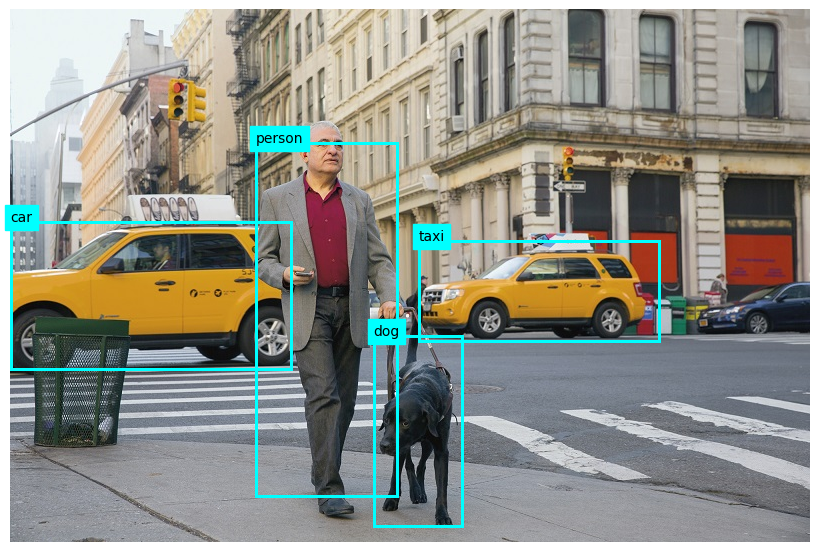

In [ ]:
# Draw bounding boxes around objects and people
# Get objects in the image
if result.objects is not None:
    print("\nObjects in image:")

    # Prepare image for drawing
    image = Image.open(image_file)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for detected_object in result.objects.list:
        # Print object name
        print(" {} (confidence: {:.2f}%)".format(detected_object.tags[0].name, detected_object.tags[0].confidence * 100))
        
        # Draw object bounding box
        r = detected_object.bounding_box
        bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height)) 
        draw.rectangle(bounding_box, outline=color, width=3)
        plt.annotate(detected_object.tags[0].name,(r.x, r.y), backgroundcolor=color)

    # Save annotated image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    outputfile = 'objects.jpg'
    fig.savefig(outputfile)
    print('  Results saved in', outputfile)


People in image:
  Results saved in people.jpg


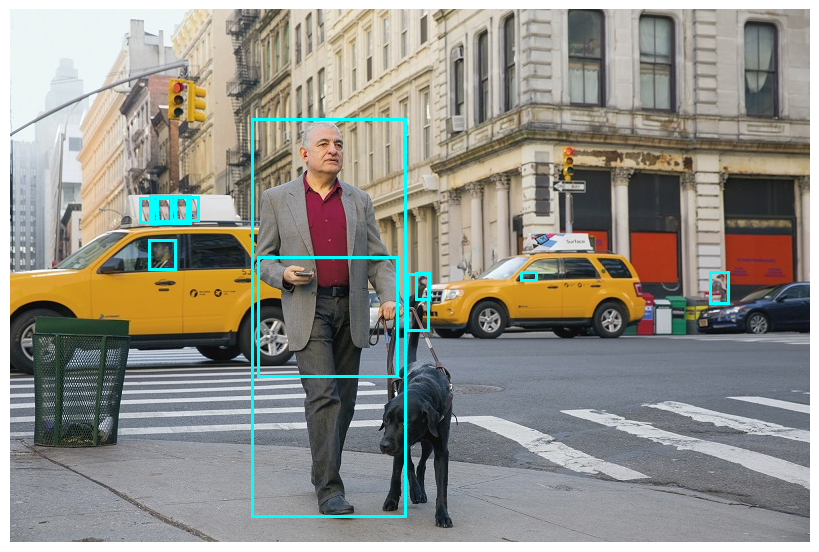

In [38]:
# Get people in the image
if result.people is not None:
    print("\nPeople in image:")

    # Prepare image for drawing
    image = Image.open(image_file)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for detected_people in result.people.list:
        # Draw object bounding box
        r = detected_people.bounding_box
        bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height))
        draw.rectangle(bounding_box, outline=color, width=3)

        # Return the confidence of the person detected
        #print(" {} (confidence: {:.2f}%)".format(detected_people.bounding_box, detected_people.confidence * 100))
        
    # Save annotated image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    outputfile = 'people.jpg'
    fig.savefig(outputfile)
    print('  Results saved in', outputfile)

Remove Background from image

In [46]:
# Remove the background from the image or generate a foreground matte
api_version = "v2"
mode = "foregroundMatting"
    
url = "{}computervision/imageanalysis:segment?api-version={}&mode={}".format(ai_endpoint, api_version, mode)

headers= {
    "Ocp-Apim-Subscription-Key": ai_key, 
    "Content-Type": "application/json" 
}

image_url="https://github.com/MicrosoftLearning/mslearn-ai-vision/blob/main/Labfiles/01-analyze-images/Python/image-analysis/{}?raw=true".format(image_file)  

body = {
    "url": image_url,
}
    
response = requests.post(url, headers=headers, json=body)

image=response.content
with open("backgroundForeground.png", "wb") as file:
    file.write(image)
print('  Results saved in backgroundForeground.png \n')

  Results saved in backgroundForeground.png 



In [48]:
url

'https://ai102-test.cognitiveservices.azure.com/computervision/imageanalysis:segment?api-version=v2&mode=foregroundMatting'